In [2]:
from os import listdir
import xarray
import cftime
import numpy as np
import matplotlib.pyplot as plt

In [3]:
HEAD_DIR = "/projects/dgs/persad_research/heat_research/data/"

TREFHTMN_ALL = HEAD_DIR + "TREFHTMN/ALL/DOWNLOAD/"
all_fut = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "20060101-20801231" in name], combine="nested", concat_dim="member")["TREFHTMN"]
all_hist = xarray.open_mfdataset([TREFHTMN_ALL + name for name in listdir(TREFHTMN_ALL) if "19200101-20051231" in name], combine="nested", concat_dim="member")["TREFHTMN"]
all_full = xarray.concat([all_hist, all_fut], dim="time")

TREFHTMN_XAER = HEAD_DIR + "TREFHTMN/XAER/DOWNLOAD/"
xaer_fut = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "20060101-20801231" in name], combine="nested", concat_dim="member")["TREFHTMN"]
xaer_hist = xarray.open_mfdataset([TREFHTMN_XAER + name for name in listdir(TREFHTMN_XAER) if "19200101-20051231" in name], combine="nested", concat_dim="member")["TREFHTMN"]
xaer_full = xarray.concat([xaer_hist, xaer_fut], dim="time")

landfrac = xarray.open_dataset(HEAD_DIR + "LANDFRAC/DOWNLOAD/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc")["LANDFRAC"].mean(dim="time")

coslat = np.cos(np.deg2rad(all_full.lat))
lat_weight = coslat / coslat.mean(dim='lat')

all_spatial = all_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()
all_spatial_mavg = all_spatial.mean(dim="member").load()

xaer_spatial = xaer_full.where(landfrac > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()
xaer_spatial_mavg = xaer_spatial.mean(dim="member").load()

In [26]:
dsuw = xaer_hist.mean(dim="member").where(landfrac.values > 0).mean(dim="lat").mean(dim="lon").load()
dsw = xaer_hist.mean(dim="member").where(landfrac.values > 0).weighted(lat_weight).mean(dim="lat").mean(dim="lon").load()

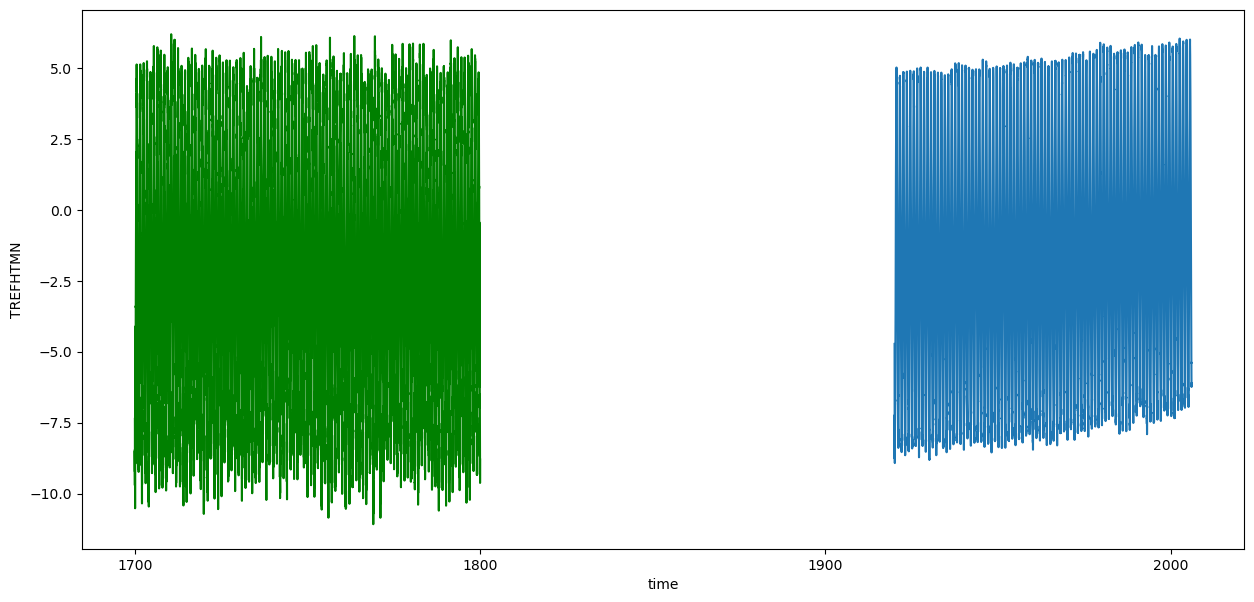

In [32]:
f, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='w')

(dsw - 273.15).plot(ax=ax)
(control - 273.15).plot(ax=ax, color="green")

In [4]:
all_spatial_y = all_spatial.resample(time="Y").mean() - 273.15
all_spatial_mavg_y = all_spatial_mavg.resample(time="Y").mean() - 273.15

xaer_spatial_y = xaer_spatial.resample(time="Y").mean() - 273.15
xaer_spatial_mavg_y = xaer_spatial_mavg.resample(time="Y").mean() - 273.15

(-28836.0, 29564.0)

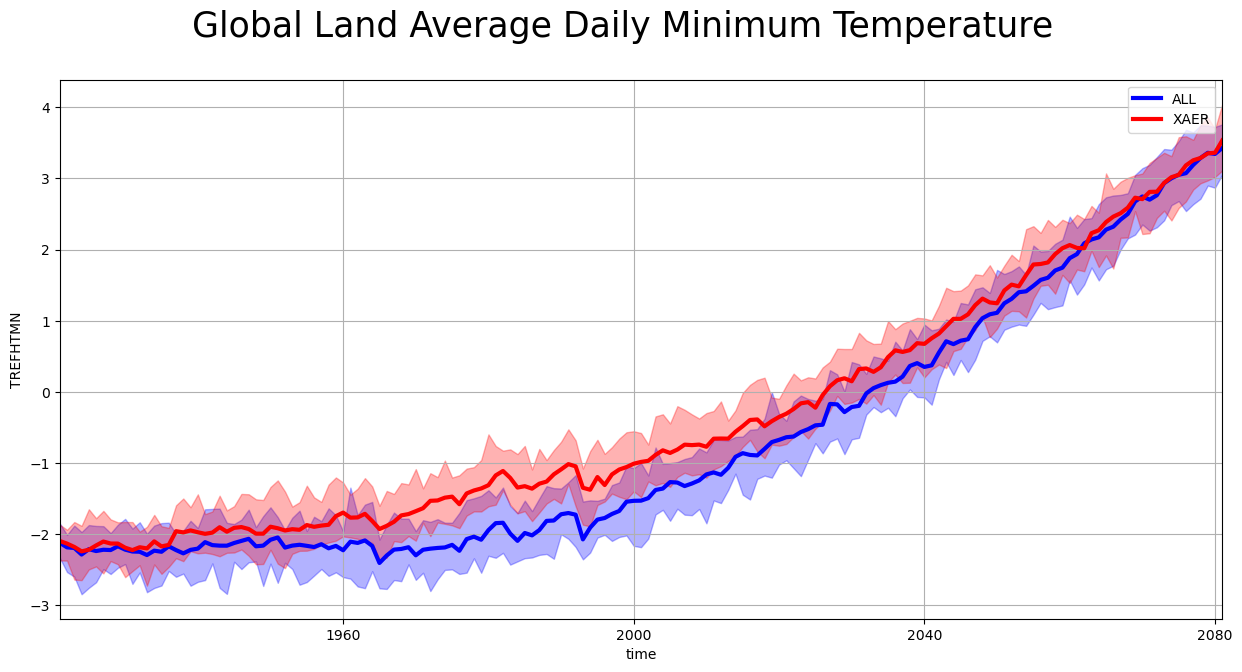

In [18]:
f, ax = plt.subplots(1, 1, figsize=(15, 7), facecolor='w')
f.suptitle("Global Land Average Daily Minimum Temperature", fontsize=25)

all_spatial_mavg_y.plot(ax=ax, color="Blue", linewidth=3, label="ALL")
ax.fill_between(all_spatial_y.time.values, all_spatial_y.min(dim="member"), all_spatial_y.max(dim="member"), color="Blue", alpha=0.3)

xaer_spatial_mavg_y.plot(ax=ax, color="Red", linewidth=3, label="XAER")
ax.fill_between(xaer_spatial_y.time.values, xaer_spatial_y.min(dim="member"), xaer_spatial_y.max(dim="member"), color="Red", alpha=0.3)

ax.legend()
ax.grid()
ax.set_xlim(all_spatial_y.time.values[0], all_spatial_y.time.values[-1])
#ax.set_ylim()

In [ ]:
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.offsetbox import AnchoredText
from paths import population_weighted_tmin_heat_outputs as ptmin, heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, land_mask
from paths import population_weighted_tmax_heat_outputs as ptmax, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax
from paths import land_mask, aod_vis_xaer_concatenated, aod_vis_all_concatenated

europe = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).mean(dim="lat").mean(dim="lon")
e_na  = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).mean(dim="lat").mean(dim="lon")
trop_s_amer  = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).mean(dim="lat").mean(dim="lon")
africa  = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).mean(dim="lat").mean(dim="lon")
se_asia  = ds.where(ds.lat>5).where(ds.lat<40).where(ds.lon>65).where(ds.lon<120).mean(dim="lat").mean(dim="lon")

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 22})
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 35), facecolor='w')
f.suptitle(f"{var} AER Regional Weighted Averages using Max. Temp.", fontsize=34)

trops_c = "orange"
na_c = "green"
africa_c = "blue"
seasia_c = "purple"
europe_c = "red"
ls = "-"
lw = 3
reg_w = 10

europep.plot(ax=ax1, linestyle=ls, linewidth=lw, color=europe_c, label="Europe")
e_nap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=na_c, label="East North America")
trop_s_amerp.plot(ax=ax1, linestyle=ls, linewidth=lw, color=trops_c, label="Tropical S. America")
africap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=africa_c, label="Central Africa")
se_asiap.plot(ax=ax1, linestyle=ls, linewidth=lw, color=seasia_c, label="India and S. Asia")